In [2]:
!pip install flwr==1.3.0
!pip install -U flwr["simulation"]
!pip install ray==2.2.0
!pip install tensorflow==2.12.0
!pip install numpy==1.22.4
!pip install matplotlib==3.7.1

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import flwr as fl
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Dense
from tensorflow.keras.optimizers import SGD
import numpy as np
import ray
from matplotlib import pyplot as plt
import pickle

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

num = 10
images = x_train[:num]
labels = y_train[:num]


In [5]:
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

## Treinamento local

In [6]:
def define_model(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(num_classes, activation='softmax'))
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
input_shape = (28, 28, 1)
num_classes = 10

model = define_model(input_shape,num_classes)

batch_size = 64
epochs = 5
local_model = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1)
    

Epoch 1/5
258/844 [========>.....................] - ETA: 14s - loss: 0.3949 - accuracy: 0.8795

KeyboardInterrupt: 

In [8]:
#plot accuracy
plt.plot(local_model.history['accuracy'])
plt.legend(['accuracy'])
plt.show()
plt.xlabel('epoch')
plt.ylabel('accuracy')



NameError: name 'local_model' is not defined

In [9]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test) -> None:
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=1, verbose=2)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}

In [10]:
def client_fn_random(cid: str) -> fl.client.Client:
    input_shape = (28, 28, 1)
    num_classes = 10
    num_clients = 10
    partition_size = 500
    

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    #sample_size_train = int(cid) * partition_size
    #sample_size_test = int(cid) * partition_size
    sample_size_train = int((1/num_clients)*len(x_train))
    sample_size_test = int((1/num_clients)*len(x_test))
    idx_train = np.random.choice(np.arange(len(x_train)), sample_size_train, replace=False)
    x_train = x_train[idx_train]/255.0
    y_train = y_train[idx_train]
    y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
    idx_test = np.random.choice(np.arange(len(x_test)), sample_size_test, replace=False)
    x_test = x_test[idx_test]/255.0
    y_test = y_test[idx_test]
    y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
    model = define_model(input_shape,num_classes)
    # Create and return client
    return FlowerClient(model, x_train, y_train, x_test, y_test)

In [11]:
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    acc = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    results = {"accuracy": sum(acc) / sum(examples)}
    return results

In [ ]:
num_clients = 10

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.9,  
    fraction_evaluate=1,  
    min_fit_clients=9,  
    min_evaluate_clients=9,  
    min_available_clients=int(
        num_clients * 0.9
    ),  
    evaluate_metrics_aggregation_fn=weighted_average,
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn_random,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    
)

INFO flwr 2023-04-18 17:47:19,260 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-18 17:47:22,647	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


: 

: 

In [12]:
#train the federated with three iterations, using 10,15,20 rounds 
#and plot the accuracy and loss for each round

num_clients = 10
num_rounds = [5,10,15,20]
histories = []

for i in num_rounds:
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=0.9,  
        fraction_evaluate=1,  
        min_fit_clients=9,  
        min_evaluate_clients=9,  
        min_available_clients=int(
            num_clients * 0.9
        ),  
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    # Start simulation
    history = fl.simulation.start_simulation(
        client_fn=client_fn_random,
        num_clients=num_clients,
        config=fl.server.ServerConfig(num_rounds=i),
        strategy=strategy,
        
    )
    histories.append(history)


INFO flwr 2023-04-18 17:48:44,991 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-18 17:48:47,375	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


KeyboardInterrupt: 

In [ ]:

# #dump the history to a file
# with open('history.pickle', 'wb') as handle:
#     pickle.dump(histories, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# load the history from a file
with open('history.pickle', 'rb') as handle:
    histories = pickle.load(handle)
    

In [ ]:
print(histories[0].metrics_distributed['accuracy'])

[(1, 0.9270999908447266), (2, 0.9556999921798706), (3, 0.9642000019550323), (4, 0.9690000057220459), (5, 0.9728000044822693)]


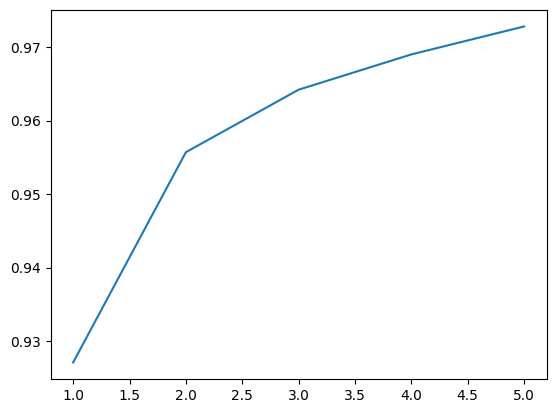

In [ ]:
plt.plot(*zip(*histories[0].metrics_distributed['accuracy']), label="5 rounds")

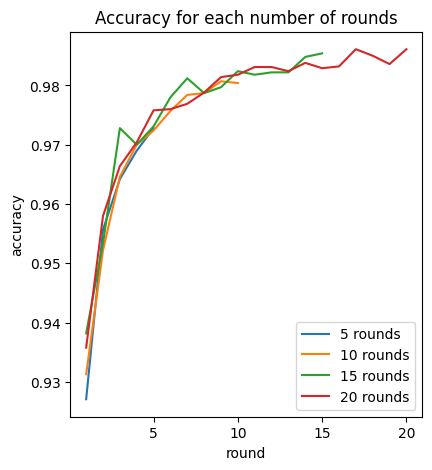

In [ ]:
#plot the accuracy for each round number
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i in range(len(histories)):
    plt.plot(*zip(*histories[i].metrics_distributed['accuracy']), label=str(num_rounds[i])+" rounds")
plt.legend()
plt.title("Accuracy for each number of rounds")
plt.xlabel("round")
plt.ylabel("accuracy")
plt.savefig('graficos/accuracy_all_rounds.png')

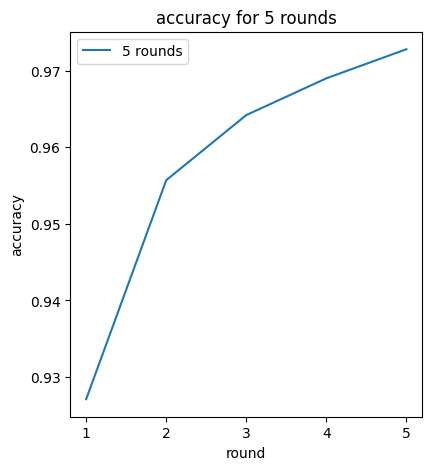

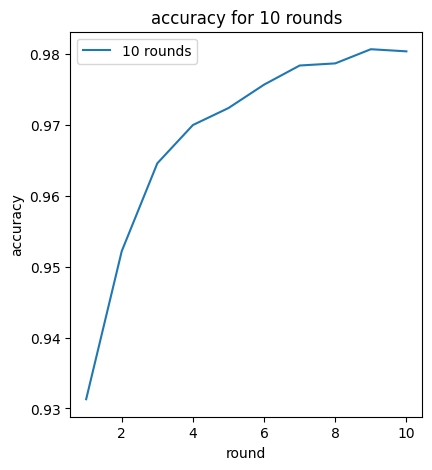

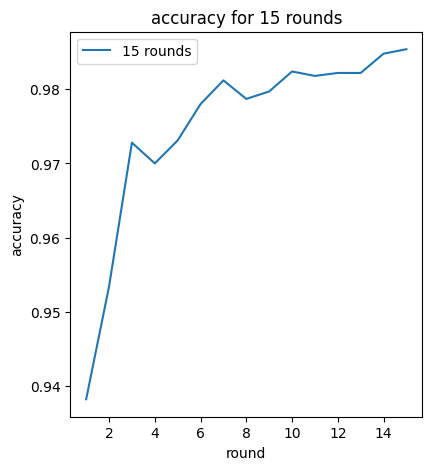

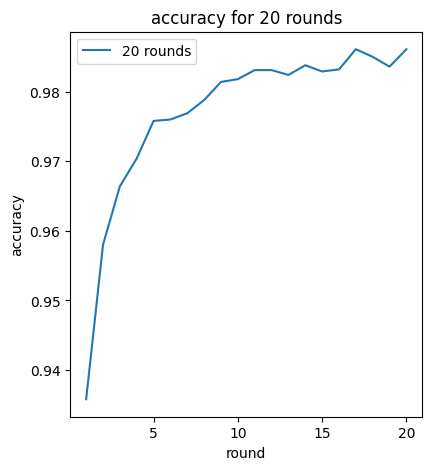

In [ ]:
#make one plot for each of the set of rounds 
for i in range(len(histories)):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(*zip(*histories[i].metrics_distributed['accuracy']), label=str(num_rounds[i])+" rounds")
    plt.legend()
    plt.title("accuracy for "+str(num_rounds[i])+" rounds")
    plt.xlabel("round")
    plt.ylabel("accuracy")
    plt.savefig('graficos/accuracy_'+str(num_rounds[i])+'_rounds.png')


In [ ]:
#plot accuracy for local_model 